<a href="https://colab.research.google.com/github/NIXBLACK11/ModelForAnalysis/blob/main/VideoRating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! rm -rf audio dataset screenshot

In [ ]:
from moviepy.video.io.VideoFileClip import VideoFileClip
import os
from PIL import Image

audioIndex = 0
imageIndex = 0
totalTime = 0

def extract_screenshots_and_audio(input_video_path, output_screenshots_folder, output_audio_folder):
    global audioIndex, imageIndex, totalTime

    # Create output folders if they don't exist
    os.makedirs(output_screenshots_folder, exist_ok=True)
    os.makedirs(output_audio_folder, exist_ok=True)

    # Load video
    video_clip = VideoFileClip(input_video_path)

    # Extract screenshots and calculate mean time duration
    screenshots = []
    mean_time_duration = 0
    for timestamp in range(0, int(video_clip.duration), 5):
        screenshot = video_clip.get_frame(timestamp)

        # Convert NumPy array to PIL Image
        pil_image = Image.fromarray(screenshot)

        screenshots.append(pil_image)
        mean_time_duration += timestamp

        screenshot_path = os.path.join(output_screenshots_folder, f"screenshot_{imageIndex}.png")
        imageIndex += 1
        pil_image.save(screenshot_path)

    totalTime += video_clip.duration

    # Extract audio
    audio = video_clip.audio
    audio_path = os.path.join(output_audio_folder, f"audio_{audioIndex}.wav")
    audio.write_audiofile(audio_path)

    audioIndex += 1  # Increment audio index for unique filenames

    # Close video clip
    video_clip.close()

if __name__ == "__main__":
    input_video_path = "/content/drive/MyDrive/VideoDataset/MrBeastType"
    output_screenshots_folder = "/content/screenshot/A"
    output_audio_folder = "/content/audio/A"

    totalFiles = 0

    for filename in os.listdir(input_video_path):
      # Construct the full file path
      input_video_file = os.path.join(input_video_path, filename)

      # Check if it's a file (not a subdirectory)
      if os.path.isfile(input_video_file):
          # Call the function with the file path
          extract_screenshots_and_audio(input_video_file, output_screenshots_folder, output_audio_folder)
          totalFiles += 1

    averageTime = totalTime / totalFiles
    print(averageTime)


MoviePy - Writing audio in /content/audio/A/audio_0.wav


MoviePy - Done.
MoviePy - Writing audio in /content/audio/A/audio_1.wav


MoviePy - Done.
MoviePy - Writing audio in /content/audio/A/audio_2.wav


MoviePy - Done.
MoviePy - Writing audio in /content/audio/A/audio_3.wav


MoviePy - Done.
MoviePy - Writing audio in /content/audio/A/audio_4.wav


MoviePy - Done.
MoviePy - Writing audio in /content/audio/A/audio_5.wav


MoviePy - Done.
MoviePy - Writing audio in /content/audio/A/audio_6.wav


MoviePy - Done.
1037.8771428571429


In [ ]:
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the paths
base_dir = '/content/screenshot'
A_dir = os.path.join(base_dir, 'A')
B_dir = os.path.join(base_dir, 'B')

# Get the list of image files
A_images = [os.path.join(A_dir, img) for img in os.listdir(A_dir)]
B_images = [os.path.join(B_dir, img) for img in os.listdir(B_dir)]

# Choose an equal number of images from both classes
num_images = min(len(A_images), len(B_images))
print(len(A_images))
print(len(B_images))
# Use only the number of B images that matches the number of A images
B_images = B_images[:num_images]
A_images = A_images[:num_images]
print(len(A_images))
print(len(B_images))

# Split the data into train and test sets
train_A, test_A = train_test_split(A_images, test_size=0.2, random_state=42)
train_B, test_B = train_test_split(B_images, test_size=0.2, random_state=42)

# Create train and test directories
train_dir = '/content/dataset/train/'
test_dir = '/content/dataset/test/'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, "A"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "B"), exist_ok=True)

os.makedirs(test_dir, exist_ok=True)
os.makedirs(os.path.join(test_dir, "A"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "B"), exist_ok=True)

# Copy images to train and test directories
for img in train_A:
    os.system(f'cp "{img}" "{os.path.join(train_dir, "A")}"')

for img in train_B:
    os.system(f'cp "{img}" "{os.path.join(train_dir, "B")}"')

for img in test_A:
    os.system(f'cp "{img}" "{os.path.join(test_dir, "A")}"')

for img in test_B:
    os.system(f'cp "{img}" "{os.path.join(test_dir, "B")}"')

# Set up image data generators for train and test sets
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)


1455
1878
1455
1455
Found 2328 images belonging to 2 classes.
Found 582 images belonging to 2 classes.


In [ ]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle

# Function to create, compile, train, and save model with a given optimizer
def train_and_save_model(optimizer_name, optimizer, train_generator, test_generator):
    # Load the VGG16 model and remove the final layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create a new model by combining the VGG16 base model and the new layers
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Freeze the VGG16 base layers and train the new layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    print(f"\nTraining model with optimizer: {optimizer_name}")

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size
    )

    # Save the model
    model.save(f'/content/drive/MyDrive/VideoDataset/video_analysis_vgg16_{optimizer_name}.h5')

    # Save the training history to a file
    history_path = f'/content/drive/MyDrive/VideoDataset/training_history_{optimizer_name}.pkl'
    with open(history_path, 'wb') as file:
        pickle.dump(history.history, file)

    return history

# Set up image data generators for train and test sets
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# List of optimizers to try
optimizers = ['adam', 'adamax', 'adadelta', 'rmsprop']

# Train and save models with different optimizers
for optimizer_name in optimizers:
    optimizer = optimizer_name
    history = train_and_save_model(optimizer_name, optimizer, train_generator, test_generator)

    # Now you can use the 'history' variable to access training metrics for plotting
    print(f'Model with optimizer {optimizer_name} - Final Training Accuracy: {history.history["accuracy"][-1]}, Final Validation Accuracy: {history.history["val_accuracy"][-1]}')


Found 2328 images belonging to 2 classes.
Found 582 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step


  history = model.fit_generator(




Training model with optimizer: adam
Epoch 1/20
72/72 [==============================] - 41s 415ms/step - loss: 0.8604 - accuracy: 0.7439 - val_loss: 0.3219 - val_accuracy: 0.8611
Epoch 2/20
72/72 [==============================] - 26s 362ms/step - loss: 0.3085 - accuracy: 0.8720 - val_loss: 0.2733 - val_accuracy: 0.8837
Epoch 3/20
72/72 [==============================] - 27s 368ms/step - loss: 0.2688 - accuracy: 0.8955 - val_loss: 0.2333 - val_accuracy: 0.9045
Epoch 4/20
72/72 [==============================] - 26s 368ms/step - loss: 0.1969 - accuracy: 0.9329 - val_loss: 0.2135 - val_accuracy: 0.9132
Epoch 5/20
72/72 [==============================] - 26s 362ms/step - loss: 0.1579 - accuracy: 0.9416 - val_loss: 0.2387 - val_accuracy: 0.9045
Epoch 6/20
72/72 [==============================] - 27s 379ms/step - loss: 0.1425 - accuracy: 0.9486 - val_loss: 0.2059 - val_accuracy: 0.9149
Epoch 7/20
72/72 [==============================] - 26s 367ms/step - loss: 0.1123 - accuracy: 0.9625 - va

  saving_api.save_model(



Model with optimizer adam - Final Training Accuracy: 0.9790940880775452, Final Validation Accuracy: 0.9114583134651184

Training model with optimizer: adamax
Epoch 1/20
72/72 [==============================] - 33s 433ms/step - loss: 0.5719 - accuracy: 0.7918 - val_loss: 0.2938 - val_accuracy: 0.8681
Epoch 2/20
72/72 [==============================] - 27s 380ms/step - loss: 0.2802 - accuracy: 0.8898 - val_loss: 0.2492 - val_accuracy: 0.8941
Epoch 3/20
72/72 [==============================] - 27s 369ms/step - loss: 0.2232 - accuracy: 0.9155 - val_loss: 0.2358 - val_accuracy: 0.9028
Epoch 4/20
72/72 [==============================] - 26s 365ms/step - loss: 0.1881 - accuracy: 0.9355 - val_loss: 0.2222 - val_accuracy: 0.9045
Epoch 5/20
72/72 [==============================] - 26s 362ms/step - loss: 0.1495 - accuracy: 0.9503 - val_loss: 0.2606 - val_accuracy: 0.8889
Epoch 6/20
72/72 [==============================] - 27s 373ms/step - loss: 0.1240 - accuracy: 0.9604 - val_loss: 0.1941 - val_a

In [ ]:
from tensorflow.keras.models import load_model

optimizers = ['adam', 'adamax', 'adadelta', 'rmsprop']

# Evaluate each model
for optimizer_name in optimizers:
    model_path = f'/content/drive/MyDrive/VideoDataset/video_analysis_vgg16_{optimizer_name}.h5'
    model = load_model(model_path)

    # Evaluate the model on the "test" set
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)

    print(f'Model with optimizer {optimizer_name} - Test accuracy: {test_acc}, Test loss: {test_loss}')


  test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)



Model with optimizer adam - Test accuracy: 0.9131944179534912, Test loss: 0.3226284980773926
Model with optimizer adamax - Test accuracy: 0.9236111044883728, Test loss: 0.2237004190683365
Model with optimizer adadelta - Test accuracy: 0.8177083134651184, Test loss: 0.41738107800483704
Model with optimizer rmsprop - Test accuracy: 0.9079861044883728, Test loss: 0.41287946701049805


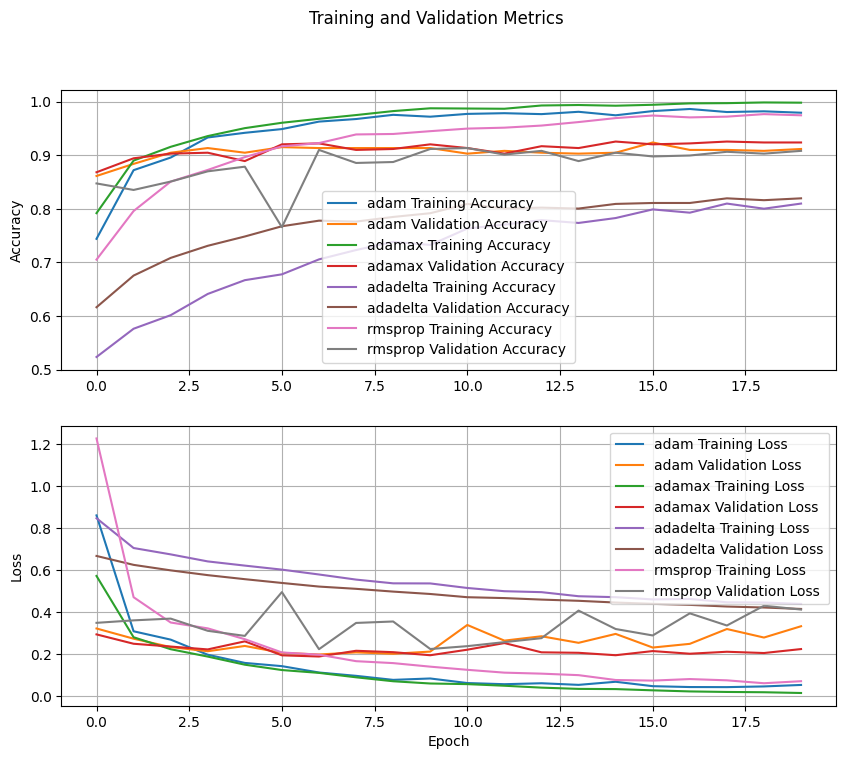

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Training and Validation Metrics')

optimizers = ['adam', 'adamax', 'adadelta', 'rmsprop']

for optimizer_name in optimizers:
    model_path = f'/content/drive/MyDrive/VideoDataset/video_analysis_vgg16_{optimizer_name}.h5'
    model = load_model(model_path)

    # Load training history
    history_path = f'/content/drive/MyDrive/VideoDataset/training_history_{optimizer_name}.pkl'  # Replace with the actual path
    with open(history_path, 'rb') as file:
        history = pickle.load(file)

    # Plot accuracy
    ax1.plot(history['accuracy'], label=f'{optimizer_name} Training Accuracy')
    ax1.plot(history['val_accuracy'], label=f'{optimizer_name} Validation Accuracy')

    # Plot loss
    ax2.plot(history['loss'], label=f'{optimizer_name} Training Loss')
    ax2.plot(history['val_loss'], label=f'{optimizer_name} Validation Loss')

# Set labels and title
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.show()


1/1 [==============================] - 1s 1s/step
Model with optimizer adam:
Selected from folder: A


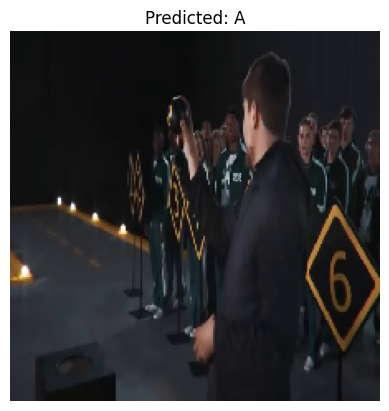

---
1/1 [==============================] - 0s 132ms/step
Model with optimizer adamax:
Selected from folder: A


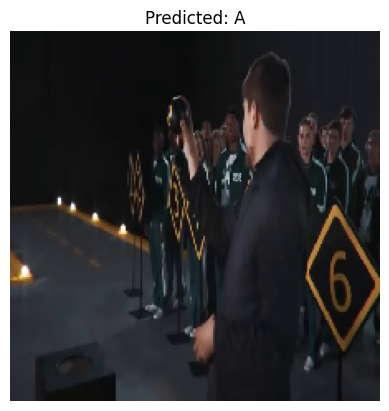

---
1/1 [==============================] - 0s 140ms/step
Model with optimizer adadelta:
Selected from folder: A


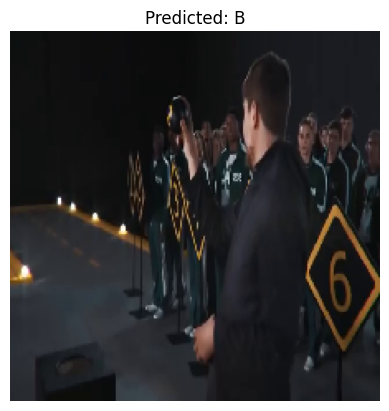

---
1/1 [==============================] - 0s 144ms/step
Model with optimizer rmsprop:
Selected from folder: A


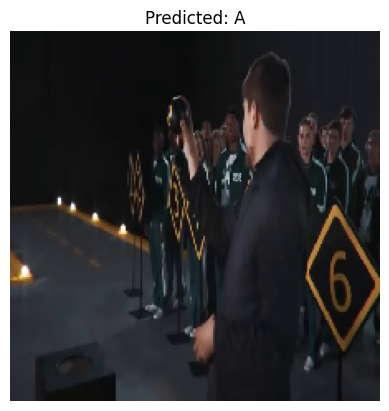

---


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Function to preprocess an image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values to be between 0 and 1
    return img_array, img

# Choose a random image from the test folder
test_images_folder = '/content/screenshot'
class_folders = ['A', 'B']
random_class = random.choice(class_folders)
random_image_name = random.choice(os.listdir(os.path.join(test_images_folder, random_class)))
random_image_path = os.path.join(test_images_folder, random_class, random_image_name)

# Preprocess the image
img, original_img = preprocess_image(random_image_path)

# Load each trained model and make predictions
optimizers = ['adam', 'adamax', 'adadelta', 'rmsprop']

for optimizer_name in optimizers:
    # Load the model
    model_path = f'/content/drive/MyDrive/VideoDataset/video_analysis_vgg16_{optimizer_name}.h5'
    model = load_model(model_path)

    # Make a prediction
    prediction = model.predict(img)

    # Display the result along with the actual image and selected folder
    plt.imshow(original_img)
    plt.axis('off')

    print(f'Model with optimizer {optimizer_name}:')
    print(f'Selected from folder: {random_class}')
    if prediction[0][0] > 0.5:
        plt.title("Predicted: B")
    else:
        plt.title("Predicted: A")
    plt.show()
    print('---')


In [25]:
from moviepy.video.io.VideoFileClip import VideoFileClip
import os
from PIL import Image

audioIndex = 0
imageIndex = 0
totalTime = 0

def extract_screenshots_and_audio(input_video_path, output_screenshots_folder, output_audio_folder):
    global audioIndex, imageIndex, totalTime

    # Create output folders if they don't exist
    os.makedirs(output_screenshots_folder, exist_ok=True)
    os.makedirs(output_audio_folder, exist_ok=True)

    # Load video
    video_clip = VideoFileClip(input_video_path)

    # Extract screenshots and calculate mean time duration
    screenshots = []
    mean_time_duration = 0
    for timestamp in range(0, int(video_clip.duration), 5):
        screenshot = video_clip.get_frame(timestamp)

        # Convert NumPy array to PIL Image
        pil_image = Image.fromarray(screenshot)

        screenshots.append(pil_image)
        mean_time_duration += timestamp

        screenshot_path = os.path.join(output_screenshots_folder, f"screenshot_{imageIndex}.png")
        imageIndex += 1
        pil_image.save(screenshot_path)

    totalTime += video_clip.duration

    # Extract audio
    audio = video_clip.audio
    audio_path = os.path.join(output_audio_folder, f"audio_{audioIndex}.wav")
    audio.write_audiofile(audio_path)

    audioIndex += 1  # Increment audio index for unique filenames

    # Close video clip
    video_clip.close()

if __name__ == "__main__":
    input_video_path = "/content/drive/MyDrive/VideoDataset/TestVideos/videoplayback (1).mp4"
    output_screenshots_folder = "/content/Test/screenshot"
    output_audio_folder = "/content/Test/audio"

    # Call the function with the video file path
    extract_screenshots_and_audio(input_video_path, output_screenshots_folder, output_audio_folder)

    # Calculate average time (if needed)
    averageTime = totalTime
    print(averageTime)


MoviePy - Writing audio in /content/Test/audio/audio_0.wav


MoviePy - Done.
905.14


In [ ]:
# Function to preprocess an image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the pixel values to be between 0 and 1
    return img_array, img


totalMin = 0
totalBeast = 0
total = 0

for image_name in os.listdir("/content/Test/screenshot"):
  # Preprocess the image
  image_path = os.path.join("/content/Test/screenshot", image_name)
  img, original_img = preprocess_image(image_path)

  # Load each trained model and make predictions
  optimizers = ['adam', 'adamax', 'adadelta', 'rmsprop']

  for optimizer_name in optimizers:
      # Load the model
      model_path = f'/content/drive/MyDrive/VideoDataset/video_analysis_vgg16_{optimizer_name}.h5'
      model = load_model(model_path)

      # Make a prediction
      prediction = model.predict(img)

      if prediction[0][0] > 0.5:
          totalMin = totalMin+1
      else:
          totalBeast = totalBeast+1

if(totalBeast>totalMin):
  print("This is a Mr.Beast Video")
else:
  print("This is a Minimalist Video")

1/1 [==============================] - 0s 144ms/step
